In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.10.1'

In [4]:
#To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

   ---------------------------------------- 0.0/313.5 kB ? eta -:--:--
   - -------------------------------------- 10.2/313.5 kB ? eta -:--:--
   --- ----------------------------------- 30.7/313.5 kB 435.7 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/313.5 kB 656.4 kB/s eta 0:00:01
   ------------------ --------------------- 143.4/313.5 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------  307.2/313.5 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 313.5/313.5 kB 1.5 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to c:\users\dell\appdata\local\temp\pip-req-build-tat2wuri
  Resolved https://github.com/tensorflow/docs to commit 9efadf0a84eae76e347787e344626650ea4ed85b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   -------------------- ------------------- 41.0/78.5 kB 2.0 MB/s eta 0:00:01
   ---

  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\DELL\AppData\Local\Temp\pip-req-build-tat2wuri'


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 6s 1us/step


In [7]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5 #Normalize images to [-1,1]

In [8]:
BUFFER_SIZE=60000
BATCH_SIZE=256

• We will pass some random noise to the Generator. The random noise will be upscaled using
Conv2DTranspose. Conv2DTranspose is used to transform a vector going in the opposite direction of
a normal convolution.

• Use LeakyReLU for the layers except for the output layer. For the output layer, we use “tanh”
activation function. LeakyReLU allows the gradients to flow better through the model architecture.

• Why Leaky ReLU? The ReLU activation function has a value between 0 and 1. When a positive input
is passed to the ReLU or LeakyReLU the output will be a positive value however, when a negative
input is passed to ReLU it will output 0, but Leaky ReLU will output a controlled negative value.

• tanh is used in the final output layer instead of sigmoid to ensure that gradients are maintained
between -1 and 1 and are not set to zero as that stops the learning for the model.

• Batch Normalization is used for faster convergence as it standardizes the data to have a stabilizing
impact on the training process.

In [9]:
#Batch and shiffle the data
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape==(None,7,7,256) #Note:None is the batch size
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape==(None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape==(None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    assert model.output_shape==(None,28,28,1)
    
    return model

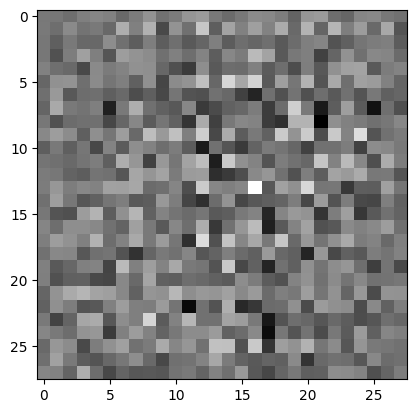

In [11]:
generator=make_generator_model()

noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0, :, :, 0],cmap='gray')

• If we use the (as yet untrained) generator to create an image.

In [12]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

• The Discriminator is a CNN-based image classifier that classifies between the real and
the fake image. It takes fake images generated from the Generator using random noise
and the real images from the training dataset as input to classify.

In [13]:
discriminator=make_discriminator_model()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.00045298]], shape=(1, 1), dtype=float32)


In [14]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

• This method quantifies how well the discriminator is able to distinguish real images from
fakes. It compares the discriminator's predictions on real images to an array of 1s, and the
discriminator's predictions on fake (generated) images to an array of 0s. Thus the
Discriminator loss is a sum of loss functions for the distribution of the data for both fake as
well as real data.

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

• The generator's loss quantifies how well it was able to trick the discriminator. Intuitively,
if the generator is performing well, the discriminator will classify the fake images as
real (or 1). Here, compare the discriminators’ decisions on the generated images to an
array of 1s.

• The loss function used in DCGAN is typically the binary cross-entropy loss, which
measures the difference between the predicted probability and the true label (0 for
generated images, 1 for real images). The discriminator and the generator optimizers are
different since you will train two networks separately.

In [17]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
EPOCHS=200
noise_dim=100
num_examples_to_generate=16

#You will reuse this seed overtime(so it's easier to visualize progress in animated GIF)
seed=tf.random.normal([num_examples_to_generate, noise_dim])

• The training loop begins with the generator receiving a random seed as input. That seed is used to
produce an image. The discriminator is then used to classify real images (drawn from the training
set) and fake images (produced by the generator).


In [31]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

• Overall, the following code represents one iteration of the training loop for a DCGAN model on the
MNIST dataset. During each iteration, a batch of real images is passed through the discriminator,
and a batch of random noise is passed through the generator to produce a batch of generated
images.

• Two gradient tapes are created, one for the generator and one for the discriminator. Gradient
tapes are used to record gradients during the forward pass, which can be used to compute
gradients for backpropagation during training. The real and generated images are passed through
the discriminator to produce a batch of outputs.

• The losses for both the generator and discriminator are computed based on the discriminator's
output for the real and generated images, and the gradients of the losses with respect to the
trainable variables for each network are computed using gradient tapes.

• These gradients are then used to update the trainable variables of the generator and discriminator
using the optimizer. The process is repeated for a specified number of iterations or epochs to train
the model.


In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start=time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
        
        #Produce images for the gif as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        #Save the model every 15 epochs
        if (epoch+1)%15==0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))
        
    #Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

• Training of the DCGAN starts, checkpoint happens every 15 epochs and produces images for GIF as
the process goes through.


In [33]:
import os
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input):
    # Ensure the directory exists
    output_dir = 'generatedimages'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate predictions
    predictions = model(test_input, training=False)

    # Set up the plot
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    # Save the image to the specified directory
    plt.savefig(f'{output_dir}/image_at_epoch_{epoch:04d}.png')
    plt.show()


• The function displays the images generated by the model passed as a parameter.

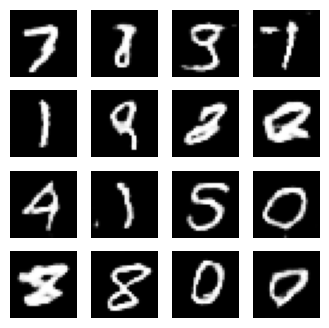

In [34]:
train(train_dataset,EPOCHS)

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

• Call the train( ) method defined above to train the generator and discriminator
simultaneously. Note, training GANs can be tricky. It's important that the generator and
discriminator do not overpower each other (e.g., that they train at a similar rate).

• At the beginning of the training, the generated images look like random noise. As training
progresses, the generated digits will look increasingly real. After about 50 epochs, they
resemble MNIST digits. This may take about one minute/epoch with the default settings
on Colab.

• Call the train function and restore the checkpoint.

In [38]:
from PIL import Image

def display_image(epoch_no):
    file_path = 'generatedimages/image_at_epoch_{:04d}.png'.format(epoch_no)
    return Image.open(file_path)


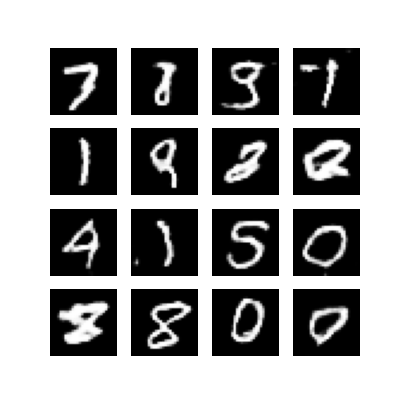

In [39]:
display_image(EPOCHS)

In [45]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # Update the path to include the directory where images are stored
    filenames = glob.glob('generatedimages/image*.png')
    filenames = sorted(filenames)  # Ensure the files are sorted by epoch
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image twice to pause at the end
    if filenames:
        image = imageio.imread(filenames[-1])
        writer.append_data(image)


C:\Users\DELL\AppData\Local\Temp\ipykernel_14388\2612665805.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14388\2612665805.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filenames[-1])



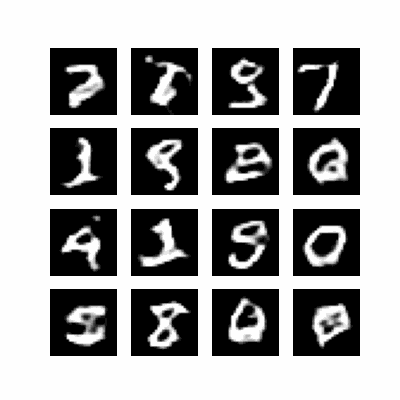

In [46]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)